<div style="text-align: center; font-weight: bold; font-size: 300%">Projet INF442</div>                                                        <br />
<div style="text-align: center; font-weight: bold; font-size: 180%">Modèles de Régression</div> <br />   
<div style="text-align: center; font-size: 150%">École Polytechnique, mai 2020</div><br />  
<div style="text-align: center; font-size: 120%">Paul Calot et Jean-Charles Layoun</div>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pylab as plt
from datetime import datetime
# Display math
from IPython.display import display, Math, Latex

# For Nicer plots
import seaborn as sn

#For regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

## Intervalle de temps des training datasets :

1. Le 28 mai de 09h17 à 15h14
2. Le 28 au 29 mai de 15h14 à 01h05
3. Le 29 mai de 06h41 à 11h42
4. Le 29 mai de 11h43 à 12h36

In [2]:
Interval = []

# Intervalle for first training set :
startTimeTr1 = datetime(2018, 5, 28, 9, 17, 0)
endtTimeTr1 = datetime(2018, 5, 28, 15, 14, 0)

Interval.append((startTimeTr1, endtTimeTr1))

# Intervalle for second training set :
startTimeTr2 = endtTimeTr1
endtTimeTr2 = datetime(2018, 5, 29, 1, 5, 0)

Interval.append((startTimeTr2, endtTimeTr2))

# Intervalle for third training set :
startTimeTr3 = datetime(2018, 5, 29, 6, 41, 0)
endtTimeTr3 = datetime(2018, 5, 29, 11, 42, 0)

Interval.append((startTimeTr3, endtTimeTr3))


# Intervalle for fourth training set :
startTimeTr4 = datetime(2018, 5, 29, 11, 43, 0)
endtTimeTr4 = datetime(2018, 5, 29, 12, 36, 0)

Interval.append((startTimeTr4, endtTimeTr4))


# Print les intervalles
for i in range(0, len(Interval)):
    print("Intervalle de temps du training_set_" + str(i+1) + " :")
    print("Début : " + Interval[i][0].strftime('%d mai à %X') + " et Fin : " + Interval[i][1].strftime('%d mai à %X'))
    print("\n")

Intervalle de temps du training_set_1 :
Début : 28 mai à 09:17:00 et Fin : 28 mai à 15:14:00


Intervalle de temps du training_set_2 :
Début : 28 mai à 15:14:00 et Fin : 29 mai à 01:05:00


Intervalle de temps du training_set_3 :
Début : 29 mai à 06:41:00 et Fin : 29 mai à 11:42:00


Intervalle de temps du training_set_4 :
Début : 29 mai à 11:43:00 et Fin : 29 mai à 12:36:00




## Nous importons les données :

Les données ont été produites par le notebook Preprocessing et Processing. Les données sont de la forme : <br>

| nom du champ | type | commentaire |
| --- | --- | --- |
| `Station number` | float | C'est l'entier désignant la station, ils sont numérotés de 0 à 46 |
| `Direction` | float | Vaut 1 pour l'aller et -1 pour le retour |
| `Announced arrival time` | float | Le temps d'arriver en minutes théorique annoncé par la RATP |
| `Travel time` | float | Le temps écoulé entre sa première apparition et son arrivée à destination en minutes. |
| `Is late ?` | booléen | Indique si la RATP l'a signalé en retard (1 si c'est le cas) |
| `Delta` | float | Temps d'arriver annoncé - temps d'arriver réelle en minutes. |

In [3]:
## Reading the data from RATP concerning RER B:

# Names of the columns :
names = ["Station number", "Direction", "Announced arrival time", "Travel time", "Is late ?", "Delta"]

# Get only first training data:
data1 = pd.read_csv("trainingdata_1_aller.csv", names = names)

# Get the third and fourth training data corresponding to 29 of may:
testingData1 = pd.concat([pd.read_csv("trainingdata_3_aller.csv", names = names),
                         pd.read_csv("trainingdata_4_aller.csv", names = names)], axis=0, ignore_index=True)

# Get all training data:
li = [data1]

for i in range (2, 5):
    if(i != 2):li.append(pd.read_csv("trainingdata_" + str(i) + "_aller.csv", names = names))

allData = pd.concat(li, axis=0, ignore_index=True)

data1

,Station number,Direction,Announced arrival time,Travel time,Is late ?,Delta
0,1.0,1.0,560.0,3.0,0.0,2.0
1,1.0,1.0,560.0,3.0,0.0,3.0
2,1.0,1.0,560.0,3.0,0.0,4.0
3,1.0,1.0,576.0,19.0,0.0,0.0
4,1.0,1.0,576.0,19.0,0.0,1.0
...,...,...,...,...,...,...
1845,46.0,1.0,799.0,89.0,0.0,0.0
1846,46.0,1.0,799.0,89.0,0.0,1.0
1847,46.0,1.0,814.0,89.0,0.0,0.0
1848,46.0,1.0,814.0,89.0,0.0,1.0


#### Nous enlevons du bruit : 

In [4]:
allData.head()

for index, row in allData.iterrows():
    if(row["Delta"] < -8):
        #print(row)
        allData = allData.drop(index)

allData.iloc[:394]        


,Station number,Direction,Announced arrival time,Travel time,Is late ?,Delta
0,1.0,1.0,560.0,3.0,0.0,2.0
1,1.0,1.0,560.0,3.0,0.0,3.0
2,1.0,1.0,560.0,3.0,0.0,4.0
3,1.0,1.0,576.0,19.0,0.0,0.0
4,1.0,1.0,576.0,19.0,0.0,1.0
...,...,...,...,...,...,...
389,10.0,1.0,745.0,43.0,0.0,4.0
390,10.0,1.0,750.0,44.0,0.0,1.0
391,10.0,1.0,760.0,42.0,0.0,5.0
394,10.0,1.0,765.0,0.0,0.0,1.0


### Matrice de corrélation du premier training dataset :

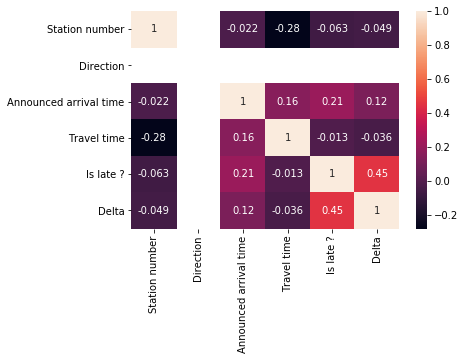

In [5]:
corrMatrix = data1.corr()
sn.heatmap(corrMatrix, annot=True) #.drop(columns=["Travel time"])
plt.show()

### Nous traçons `Delta` en fonction de `isLate` pour identifier la dépendance :

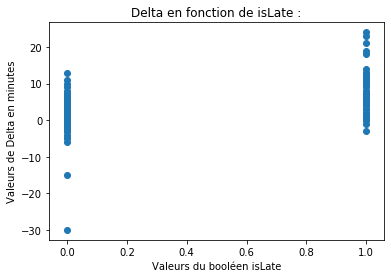

In [6]:
## Plotting Delta to is late:
plt.scatter(data1["Is late ?"], data1["Delta"])

plt.xlabel("Valeurs du booléen isLate")
plt.ylabel("Valeurs de Delta en minutes")
plt.title("Delta en fonction de isLate :")
plt.show()

## On observe une petite augmentation de delta selon s'il a été annoncé en retard ou pas,
## Ce comportement est rassurant. La RATP annonce donc bien ses retards. 

##### Il est clair que `Delta` est supérieur en moyenne lorsque la RATP annonce un retard. Ce qui est rassurant.

### Nous traçons `Announced Arrival` Time en fonction de `Delta` pour identifier la dépendance :

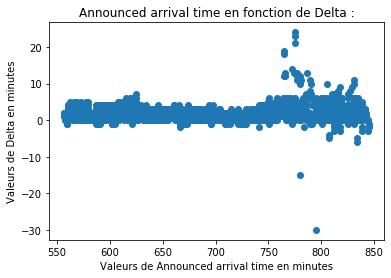

In [7]:
## Plotting Delta to is Announced arrival time:
plt.scatter(data1["Announced arrival time"], data1["Delta"])

plt.xlabel("Valeurs de Announced arrival time en minutes")
plt.ylabel("Valeurs de Delta en minutes")
plt.title("Announced arrival time en fonction de Delta :")
plt.show()

## Peu de variation de delta selon Announced arrival time, ce qui explique la faible corrélation

## Premier modèle de régression:

Même si en théorie, lorsque la RATP annonce qu'un train est en retard il devrait l'être, il reste quand même intéressant d'étudier l'impacte de leur annonce sur le retard des trains avec ce simple modèle de régression linéaire :

$$ Y = \beta_{0} + \beta_{1}X$$


<br>
où: 
<center> Y est le retard en minutes</center>
<center>X est le booléen "isLate" qui vaut 0 ou 1 (dummy var)</center>

<br>

##### Questionnement :

</br>

1. Est-ce que la RATP réussit à annoncer la grande majorité des retards ?
2. Est-ce qu'elle se trompe ?
3. Si oui quelles sont les proportions d'erreurs de ces annonces ?


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

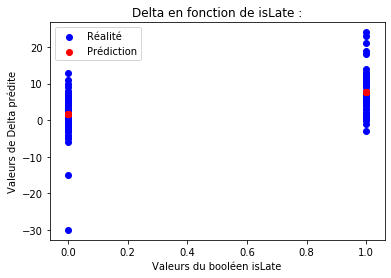

In [8]:
# Variable chosen:
X = pd.DataFrame(data1["Is late ?"])
y = pd.DataFrame(data1["Delta"])


model1 = LinearRegression()

## Splits the training data into 3 sets :
"""
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
print(scores)
"""

model1.fit(X, y)
score1 = model1.score(X, y)
Beta1_m1 = model1.coef_[0][0]
Beta0_m1 = model1.intercept_[0]

display(Math(r'R^2_1 = {0}'.format(score1.round(5))) )
display(Math(r'\beta_0 = {0}'.format(Beta0_m1.round(5))) )
display(Math(r'\beta_1 = {0}'.format(Beta1_m1.round(5))) )

# Predicts
y_pred = Beta0_m1 + Beta1_m1 * X.to_numpy()

## On trace la nouvelle courbe:

# Réalité
plt.scatter(data1["Is late ?"], data1["Delta"], color = "blue", label = "Réalité")

# Prédictions
plt.scatter(X.to_numpy(), y_pred, color = "red", label = "Prédiction")



plt.xlabel("Valeurs du booléen isLate")
plt.ylabel("Valeurs de Delta prédite")

plt.legend()

plt.title("Delta en fonction de isLate :")
plt.show()

#### Observations :

1. Le modèle explique très peu les retards des trains en minutes, $R^2$ = 0.194. Ceci est dû à la variance des retards en minutes qu'il peut y avoir. (Pas très choquant.)
2. Par contre, un comportement quand même rassurant c'est que lorsque la RATP signale le retard le train prend en moyenne  5.6 minutes de retard de plus. Les trains donc signalés en retard sont en moyenne plus en retard !
3. Toute fois nous n'avons pas répondu à la question est-ce que la RATP se trompe. Nous comptons le faire dans la partie qui suit.
4. En ajoutant toutes les données de l'aller, $R^2$ diminue jusqu'à 18.4, c'est surement dû à l'ajout du bruit par le fichier trainingdata_2_aller. Le bruit est observable par le dernier tracé de ce document. C'est pour cela qu'on entraine le modèle sur data1.
5. Il serait aussi intéressant de voir si nous pouvons améliorer le modèle si nous y ajoutons les dates annoncées de la RATP.


### Combien de fois la RATP se trompe-t-elle ?

In [9]:
## Le nombre de fois où ils disent que le train est en retard et il ne l'est pas:
countFalseAlarams = 0
for index, row in data1.iterrows():
    if(row["Delta"] <= 0 and row["Is late ?"]):
        #print(row)
        countFalseAlarams += 1
        
print("Taux de fausses alarmes de la RATP : " + str(countFalseAlarams / data1.shape[0] * 100)[:6]  + "%")
print("\n")
print("Ce taux est assez bas, ce qui peut refléter la politique de la RATP sur les annonces des retard, minimiser les faux positifs.")

Taux de fausses alarmes de la RATP : 0.2162%


Ce taux est assez bas, ce qui peut refléter la politique de la RATP sur les annonces des retard, minimiser les faux positifs.


In [10]:
## Le nombre de fois où ils ne disent pas que le train est en retard et il l'est:
countFalseNegatives = 0
for index, row in data1.iterrows():
    ## On considère qu'il est vraiment en retard à partir de 4 min:
    if(row["Delta"] >  4 and not(row["Is late ?"]) ):
        #print(row)
        countFalseNegatives += 1
        
print("Taux de faux négatifs : " + str( (countFalseNegatives / data1.shape[0] * 100) )[:6]  + "%")
print("\n")
print("Ce taux est bas, ils ne se trompent pas au tant qu'on ne peut le penser...")

Taux de faux négatifs : 5.5135%


Ce taux est bas, ils ne se trompent pas au tant qu'on ne peut le penser...


##### Quid du temps annoncé ?

In [11]:
## Le nombre de fois où la RATP se trompe dans son heure d'arriver:

nbreOfT = 5
countErrors = [0 for i in range(0,nbreOfT)]
precisions = [1, 3, 4, 6, 10]

for index, row in data1.iterrows():
    ## On compte les mauvaises annonce selon la précision qui varie:
    
    for i in range (0 , nbreOfT):
        if(abs(row["Delta"]) >  precisions[i] ):
            #print(row)
            countErrors[i] += 1

for i in range (0  ,nbreOfT):    
    minute = " minute " if i==0 else " minutes "
    print("Taux de mauvaises annonces à " + str(precisions[i]) + minute + "près : " + str( (countErrors[i] / data1.shape[0] * 100) )[:6]  + "%")
    print("\n")
    

Taux de mauvaises annonces à 1 minute près : 51.891%


Taux de mauvaises annonces à 3 minutes près : 14.594%


Taux de mauvaises annonces à 4 minutes près : 8.1081%


Taux de mauvaises annonces à 6 minutes près : 2.0540%


Taux de mauvaises annonces à 10 minutes près : 1.0810%




##### Donc 85% des annonces sont bonnes à 3 minutes près. Ce qui est déjà très bien.

## Second modèle de régression:

Il nous reste à voir si la date d'arriver annoncée nous permet de mieux expliquer les retards du RER B, ajoutons-le au modèle :

$$ Y = \beta_{0} + \beta_{1}X_1 + \beta_{2}X_2 $$

où :
<br>
<center>Y est le retard en minutes,</center>
<center>$X_1$ est le booléen "isLate" qui vaut 0 ou 1 (dummy var)</center>
<center>$X_2$ est la variable "Announced arrival time" en minutes</center>

</br></br>


In [12]:
X2 = pd.DataFrame(data1[["Is late ?", "Announced arrival time"]])
y = pd.DataFrame(data1["Delta"])


model2 = LinearRegression()
model2.fit(X2, y)

score2 = model2.score(X2, y)
Beta2 = model2.coef_[0][0]
Beta1 = model2.coef_[0][0]
Beta0 = model2.intercept_[0]

display(Math(r'R^2_2 = {0}'.format(score2.round(5))) )
display(Math(r'\beta_0 = {0}'.format(Beta0.round(5))) )
display(Math(r'\beta_1 = {0}'.format(Beta1.round(5))) )
display(Math(r'\beta_2 = {0}'.format(Beta2.round(5))) )


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### Très faible augmentation de $R^2$, `Announced arrival time` ajoute très peu d'informations au modèle. En plus $\beta_2$ est très faible ! Son impacte est vraiment mininme. Rien d'inatendu puisque les annonces ne devraient pas influer sur le retard du train. 

## Troisième modèle de régression:

L'objectif initiale était de voir si nous pouvons avec les données que nous avons récolté, mieux prédire le retard que la RATP. D'où l'existance du troisième modèle où nous prenons en compte toutes les variables :

$$ Y = \beta_{0} + \beta_{1}X_1 + \beta_{2}X_2 + \beta_{3}X_3 + \beta_{4}X_4 $$

où :
<br>
<center>Y est le retard en minutes,</center>
<center>$X_1$ est le booléen "isLate qui" vaut 0 ou 1 (dummy var)</center>
<center>$X_2$ est la variable "Announced arrival time" en minutes</center>
<center>$X_3$ est la variable "Travel time" en minutes</center>
<center>$X_4$ est la variable "Station number" en minutes</center>

</br></br>


In [13]:
X3 = pd.DataFrame(data1[["Is late ?", "Announced arrival time", "Travel time", "Station number"]])
y = pd.DataFrame(data1["Delta"])


model3= LinearRegression()
model3.fit(X3, y)

score3 = model3.score(X3, y)
Beta4 = model3.coef_[0][3]
Beta3 = model3.coef_[0][2]
Beta2 = model3.coef_[0][1]
Beta1 = model3.coef_[0][0]
Beta0 = model3.intercept_[0]

display(Math(r'R^2_3 = {0}'.format(score3.round(5))) )
display(Math(r'\beta_0 = {0}'.format(Beta0.round(5))) )
display(Math(r'\beta_1 = {0}'.format(Beta1.round(5))) )
display(Math(r'\beta_2 = {0}'.format(Beta2.round(5))) )
display(Math(r'\beta_3 = {0}'.format(Beta3.round(5))) )
display(Math(r'\beta_4 = {0}'.format(Beta4.round(5))) )

display(Math(r'R^2_3 - R^2_1 = {0}'.format((score3 - score1).round(5))))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### Ce modèle a un $R^2$ plus élevé de 0.003 par rapport au modèle 1, ce qui veut dire qu'on peut un peu mieux prédire les retard en minutes que seulement avec le message de retard de la RATP pour data1. Voyons voir si c'est le cas sur le testingdata1.

## Comparons la précision des prédictions du modèle 1 au modèle 3

In [14]:
## La journée du 29 mai:
testingData1

Xtest3 = pd.DataFrame(testingData1[["Is late ?", "Announced arrival time", "Travel time", "Station number"]])
Xtest1 = pd.DataFrame(testingData1["Is late ?"])
ytest = pd.DataFrame(testingData1["Delta"])

display(Math(r'Rtest^2_1 = {0}'.format((model1.score(Xtest1, ytest)).round(5))))
display(Math(r'Rtest^2_3 = {0}'.format((model3.score(Xtest3, ytest)).round(5))))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Conclusion :

Le $R^2$ du modèle 1 est supérieure à celui du modèle 3.
<br>
Le fait que nous prenons plus de variables en compte que le modèle 1 peut expliquer une meilleur adaptations au training set ce qui résulte en un `overfitting`. En effet, sur le training set `data1`, le score du modèle 3 est supérieure au modèle 1 ce qui est l'inverse ici.

### Voyons si nous prédisons les heures d'arriver mieux que la RATP sur `data1` :

In [15]:
X3_np = X3.to_numpy()
y_pred = Beta0 + Beta1 * X3_np[:,0] + Beta2 * X3_np[:,1] + Beta3 * X3_np[:,2] + Beta4 * X3_np[:,3]


## Le nombre de fois où nous nous trompons:

nbreOfT = 5
countOurErrors = [0 for i in range(0,nbreOfT)]
precisions = [1, 3, 4, 6, 10]

for index, row in data1.iterrows():
    ## On compte les mauvaises annonce selon la précision qui varie:
    
    for i in range (0 , nbreOfT):
        if(abs(row["Delta"] - y_pred[index - 1]) >  precisions[i] ):
            #print(row)
            countOurErrors[i] += 1

for i in range (0, nbreOfT):
    minute = " minute " if i==0 else " minutes " 
    print("Taux de mauvaises prédictions à " + str(precisions[i]) + minute + "près : " + str( (countOurErrors[i] / data1.shape[0] * 100) )[:6]  + "%")
    print("\n")


Taux de mauvaises prédictions à 1 minute près : 43.945%


Taux de mauvaises prédictions à 3 minutes près : 8.9729%


Taux de mauvaises prédictions à 4 minutes près : 4.3243%


Taux de mauvaises prédictions à 6 minutes près : 1.5135%


Taux de mauvaises prédictions à 10 minutes près : 0.6486%




##### Donc 92% des prédictions de notre modèle sont bonnes à 3 minutes près. Ce qui est 6% mieux que la RATP.

Il reste quand même à voir si avec nos données d'apprentissage, nous pouvons mieux faire que la RATP sur un nouveau jeu de donnée.

## Voyons si nous prédisons les heures d'arriver mieux que la RATP sur `testingData1` :

### Erreurs de la RATP sur `testingData1` :

In [16]:
## Le nombre de fois où la RATP se trompe dans son heure d'arriver:

nbreOfT = 5
countErrors = [0 for i in range(0,nbreOfT)]
precisions = [1, 3, 4, 6, 10]

for index, row in testingData1.iterrows():
    ## On compte les mauvaises annonce selon la précision qui varie:
    
    for i in range (0 , nbreOfT):
        if(abs(row["Delta"]) >  precisions[i] ):
            #print(row)
            countErrors[i] += 1

for i in range (0  ,nbreOfT):
    minute = " minute " if i==0 else " minutes "
    print("Taux de mauvaises annonces à " + str(precisions[i]) + minute + "près : " + str( (countErrors[i] / testingData1.shape[0] * 100) )[:6]  + "%")
    print("\n")
    

Taux de mauvaises annonces à 1 minute près : 53.726%


Taux de mauvaises annonces à 3 minutes près : 15.235%


Taux de mauvaises annonces à 4 minutes près : 8.4905%


Taux de mauvaises annonces à 6 minutes près : 4.1981%


Taux de mauvaises annonces à 10 minutes près : 0.7075%




### Erreurs de notre modèle 3 sur `testingData1` :

In [17]:
Xtest3_np = Xtest3.to_numpy()
y_pred2 = Beta0 + Beta1 * Xtest3_np[:,0] + Beta2 * Xtest3_np[:,1] + Beta3 * Xtest3_np[:,2] + Beta4 * Xtest3_np[:,3]


## Le nombre de fois où nous nous trompons:

nbreOfT = 5
countOurErrors = [0 for i in range(0,nbreOfT)]
precisions = [1, 3, 4, 6, 10]

for index, row in testingData1.iterrows():
    ## On compte les mauvaises annonce selon la précision qui varie:
    
    for i in range (0 , nbreOfT):
        if(abs(row["Delta"] - y_pred2[index - 1]) >  precisions[i] ):
            #print(row)
            countOurErrors[i] += 1

for i in range (0  ,nbreOfT):
    minute = " minute " if i==0 else " minutes "
    print("Taux de mauvaises prédictions à " + str(precisions[i]) + minute + "près : " + str( (countOurErrors[i] / testingData1.shape[0] * 100) )[:6]  + "%")
    print("\n")


Taux de mauvaises prédictions à 1 minute près : 46.556%


Taux de mauvaises prédictions à 3 minutes près : 8.3962%


Taux de mauvaises prédictions à 4 minutes près : 5.2830%


Taux de mauvaises prédictions à 6 minutes près : 1.9339%


Taux de mauvaises prédictions à 10 minutes près : 0.1415%




#### Conclusion :

1. Ici, la différence entre nos prédictions et celles de la RATP sont moins grandes que pour le training dataset `data1`, 7% mieux que la RATP pour un intervalle de 3 minutes.<br>
2. Juste grâce aux données prises d'Open Data de 9h à 15h du 28 mai 2018, nous réusissons à mieux prédire les retards que la RATP. Ce qui est déjà pas mal considérant le peu d'informations utilisées.

### Erreurs de notre modèle 1 sur `testingData1` :

In [18]:
Xtest1_np = Xtest1.to_numpy()
y_pred3 = Beta0_m1 + Beta1_m1 * Xtest1_np

## Le nombre de fois où nous nous trompons:

nbreOfT = 5
countOurErrors = [0 for i in range(0,nbreOfT)]
precisions = [1, 3, 4, 6, 10]

for index, row in testingData1.iterrows():
    ## On compte les mauvaises annonce selon la précision qui varie:
    
    for i in range (0 , nbreOfT):
        if(abs(row["Delta"] - y_pred3[index - 1]) >  precisions[i] ):
            #print(row)
            countOurErrors[i] += 1

for i in range (0  ,nbreOfT):
    minute = " minute " if i==0 else " minutes "
    print("Taux de mauvaises prédictions à " + str(precisions[i]) + minute + "près : " + str( (countOurErrors[i] / testingData1.shape[0] * 100) )[:6]  + "%")
    print("\n")


Taux de mauvaises prédictions à 1 minute près : 46.556%


Taux de mauvaises prédictions à 3 minutes près : 8.3962%


Taux de mauvaises prédictions à 4 minutes près : 5.2830%


Taux de mauvaises prédictions à 6 minutes près : 1.9339%


Taux de mauvaises prédictions à 10 minutes près : 0.1415%




## Matrice de corrélation de tout le training dataset :

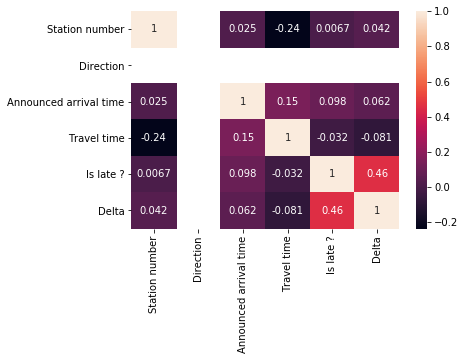

In [19]:
sn.heatmap(allData.corr(), annot=True)
plt.show()

###### C'est à peu près la même matrice de corrélation qu'avec data1.

### Nous traçons `Announced arrival time` en fonction de `Delta` pour identifier le bruit : 

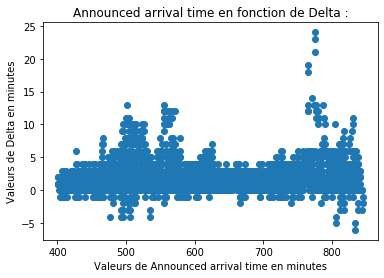

In [20]:
## Plotting Delta to is Announced arrival time:
plt.scatter(allData["Announced arrival time"], allData["Delta"])

plt.xlabel("Valeurs de Announced arrival time en minutes")
plt.ylabel("Valeurs de Delta en minutes")
plt.title("Announced arrival time en fonction de Delta :")
plt.show()


## La variance est plus élevée que pour data1, nous onbservons plus de bruits.